In [114]:
## Imports
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
plt.rcParams["figure.figsize"] = (20,10)

In [116]:
df_patient = pd.read_csv("australia_covid_no_dup.csv")
df_pcr = pd.read_csv("clean_pcr.csv")

# Exploratory Data Analysis

Pour analyser ces données maintenant qu'elles ont été nettoyées, on va commencer par établir les questions auxquelles on voudrait répondre :

- quelle est la prévalence de la maladie dans la population entière ?
- quelle est la prévalence de la maladie selon les âges ?
- quelle est la prévalence de la maladie géographiquement ?


On commence par joindre les deux bases de données grâce à la valeur de `patient_id`.



In [117]:
full_df = df_patient.merge(df_pcr, on="patient_id", how="inner")

In [118]:
print(full_df.columns, len(full_df))

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'patient_id', 'given_name', 'surname',
       'street_number', 'address_1', 'address_2', 'suburb', 'postcode',
       'state', 'state_corrected', 'date_of_birth', 'dob_date', 'age',
       'age_inferred', 'test_year', 'phone_number', 'phone_format',
       'phone_geo', 'all_info', 'processed', 'original', 'group',
       'Unnamed: 0_y', 'pcr'],
      dtype='object') 8632


## 1. Prévalence de la maladie dans la population totale

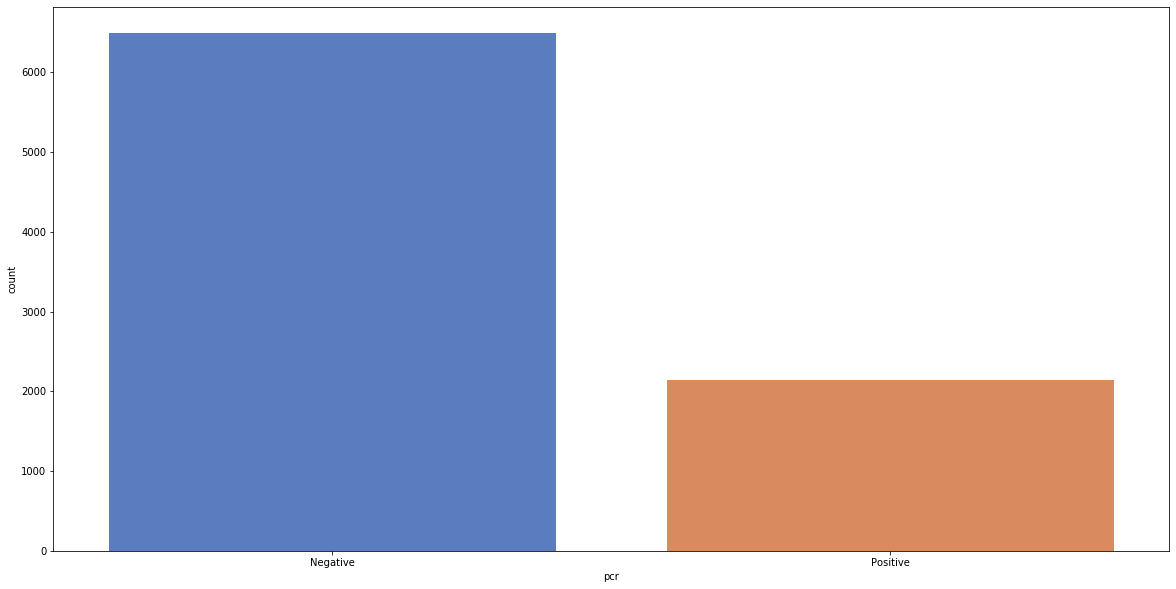

In [138]:
sns.countplot(data = full_df, x="pcr", palette="muted")


Sur l'ensemble de la population, on compte trois fois plus de tests négatifs que de tests positifs.

## 2. Prévalence de la maladie selon les âges

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


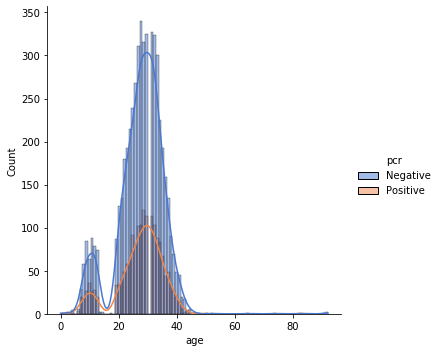

In [135]:
sns.displot(data=full_df, x="age", hue="pcr", kde=True, palette="muted")

Il ne semble pas y avoir un âge auquel la maladie est prévalente, la courbe suit la tendance du nombre de tests réalisés.

## 3. Prévalence de la maladie selon la localisation géographique

state_corrected
act    0.258621
nsw    0.244874
nt     0.098039
qld    0.250812
sa     0.222037
tas    0.262009
vic    0.262827
wa     0.253772
dtype: float64

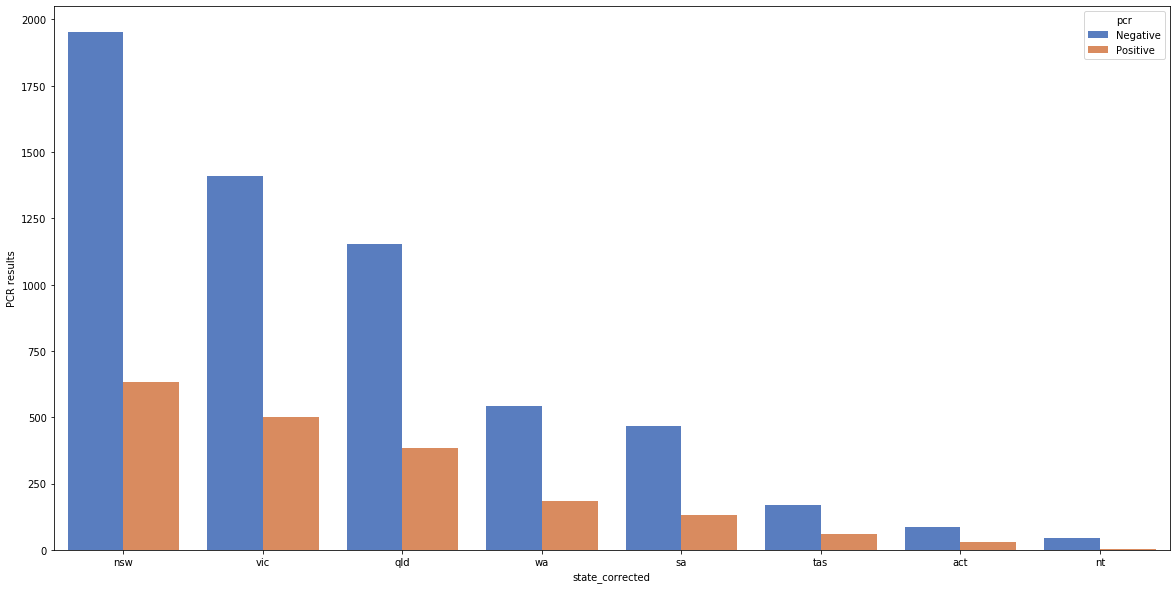

In [134]:
(full_df.state_corrected
 .groupby(full_df.pcr)
 .value_counts()
 .rename("PCR results")
 .reset_index()
 .pipe((sns.barplot, "data"), x="state_corrected", y="PCR results", hue="pcr", palette="muted"))

full_df["result_pcr"] = full_df.apply(lambda row: 0 if row.pcr in ["N", "Negative"] else 1, axis=1)

(full_df
.groupby("state_corrected")
.aggregate({"result_pcr": "sum", "patient_id": "count"})
.apply(lambda row: row["result_pcr"]/row["patient_id"], axis=1))



La tendance semble être la même dans tous les états d'Australie avec environ 25% des tests qui reviennent positifs, sauf peut-être dans NT mais c'est sûrement dû au nombre très limité de tests dans cet état. On peut aussi regarder les tests par état et par âge.

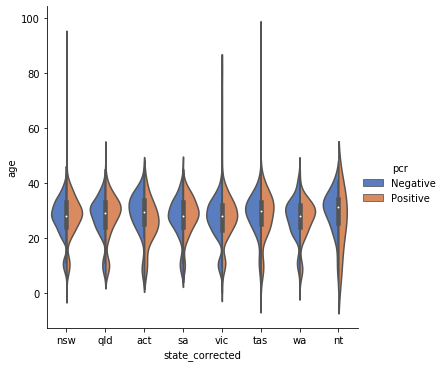

In [133]:
sns.catplot(data=full_df, kind="violin", x="state_corrected", y="age", hue="pcr", split=True, palette="muted")

Il ne semble pas y avoir de différence significative entre la répartition des résultats de PCR par âge par état, à part:

- toujours NT, ce qui peut être dpu au nombre limité de points de contrôle
- ACT, qui semble avoir une légère dissymétrie dans les résultats, les plus jeunes (20-25) ayant une proportion de tests positifs plus grande que les 30-40 ans.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


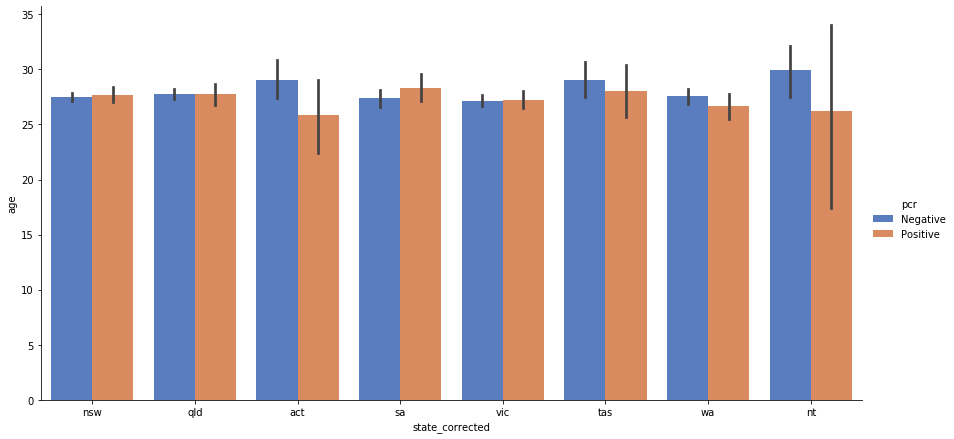

In [132]:
sns.factorplot("state_corrected", "age", "pcr", data=full_df, kind="bar", size=6, aspect=2, legend=True, palette="muted")

On retrouve ACT et NT où la différence entre positifs et négatifs est plus flagrante, et la moyenne des âges pour les personnes ayant été testées positives est plus basse que celle des négatifs dans la plupart des états, mais il n'y a pas de différence significative. 

In [139]:
import geopandas

In [140]:
geo_australia = geopandas.read_file('Igismap')

In [174]:
states_name = {"New South Wales":"nsw", 
               "Queensland":"qld", 
               "Australian Capital Territory":"act", 
               "South Australia":"sa", 
               "Victoria":"vic", 
               "Tasmania":"tas", 
               "Western Australia":"wa", 
               "Northern Territory":"nt"}

In [170]:
grouped_stats = (full_df
.groupby("state_corrected")
.aggregate({"result_pcr": "sum", "patient_id": "count"})
.apply(lambda row: row["result_pcr"]/row["patient_id"], axis=1))

geo_australia["percent_pos"] = geo_australia.apply(lambda row: grouped_stats[states_name[str(row.enname)]] if str(row.enname) in states_name.keys() else None, axis=1)
geo_australia.head(5)

#print("Australian Capital Territory" in states_name.keys())

,id,country,name,enname,locname,offname,boundary,adminlevel,wikidata,wikimedia,timestamp,note,path,rpath,iso3166_2,geometry,percent_pos
0,80500,AUS,Australia,Australia,Australia,Commonwealth of Australia,administrative,2,Q408,en:Australia,2020-01-01 22:53:02,None,"0,80500","80500,0",None,"MULTIPOLYGON (((158.68438 -55.11444, 158.68558...",NaN
1,2559345,AUS,Ashmore and Cartier Islands,Ashmore and Cartier Islands,Ashmore and Cartier Islands,None,administrative,4,Q133888,en:Ashmore and Cartier Islands,2019-10-29 23:56:02,None,"0,80500,2559345","2559345,80500,0",None,"MULTIPOLYGON (((123.55712 -12.53121, 123.55639...",NaN
2,2354197,AUS,Australian Capital Territory,Australian Capital Territory,Australian Capital Territory,None,administrative,4,Q3258,en:Australian Capital Territory,2019-11-26 10:31:02,None,"0,80500,2354197","2354197,80500,0",AU-ACT,"POLYGON ((148.76280 -35.49551, 148.76336 -35.4...",0.258621
3,2177207,AUS,Christmas Island,Christmas Island,Christmas Island,Territory of Christmas Island,administrative,4,Q31063,en:Christmas Island,2019-10-29 23:56:02,None,"0,80500,2177207","2177207,80500,0",None,"POLYGON ((105.62323 -10.46248, 105.62349 -10.4...",NaN
4,82636,AUS,Cocos (Keeling) Islands,Cocos (Keeling) Islands,Cocos (Keeling) Islands,Territory of the Cocos (Keeling) Islands,administrative,4,Q36004,en:Cocos (Keeling) Islands,2019-10-29 23:56:02,None,"0,80500,82636","82636,80500,0",None,"MULTIPOLYGON (((96.92307 -12.18210, 96.92310 -...",NaN


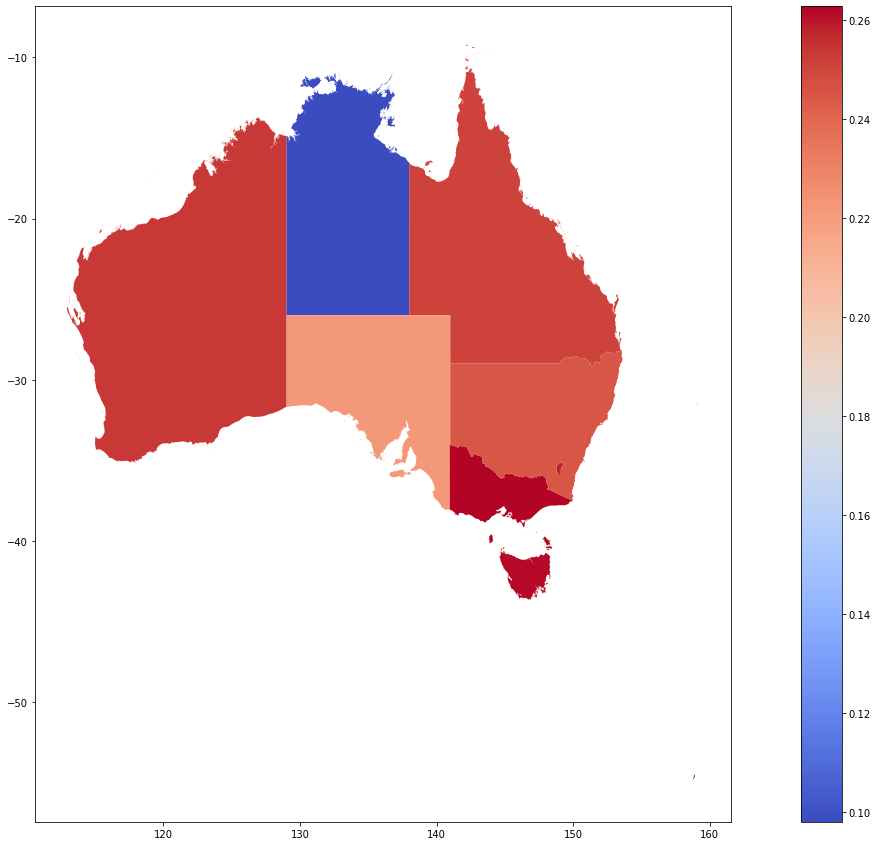

In [173]:
geo_australia.plot(column='percent_pos',figsize=(25, 15),legend=True,cmap='coolwarm')

On voit à nouveau la différence de proportion de tests positifs dans le territoire Northern Territory, que l'on peut imputer au manque de données pour ce lieu. On pourrait aussi regarder la distribution des cas selon la population de chaque état, en intégrant au projet une nouvelle base de données avec le nombre d'habitants de chaque état, afin de définir une proportion de la population ayant été testée.